In [74]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torchvision import transforms
import numpy as np
from PIL import Image
import os
from matplotlib import  pyplot as plt

random_state = 123435647

In [65]:
class HASYDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with paths and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [66]:
# Load data
root_dir = "/home/jules/Dokumente/symb-rec/"
data = pd.read_csv(os.path.join(root_dir, "hasy-data-labels.csv"))

symbols_df = pd.read_csv(os.path.join(root_dir, "symbols.csv"))

# Adjust symbol_id to start from 1
symbol_id_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted(data["symbol_id"].unique()), 0)}
data["symbol_id"] = data["symbol_id"].map(symbol_id_mapping)



label_list = data["symbol_id"].unique()
num_classes = len(label_list)
image_size = 16

batch_size = 64
log_interval = 20  # How often to display (batch) loss during training
epochs = 2  # Number of epochs
learningRate = 0.001  # learning rate
learningMomentum = 0.9  # momentum of SGD


# Split data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=random_state)
test_data, val_data = train_test_split(
    test_data, test_size=0.5, random_state=random_state
)


# Transformations / normalization
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to a PyTorch tensor
    ]
)

# Create dataset objects
train_dataset = HASYDataset(train_data, root_dir=root_dir, transform=transform)
val_dataset = HASYDataset(val_data, root_dir=root_dir, transform=transform)
test_dataset = HASYDataset(test_data, root_dir=root_dir, transform=transform)

# Create DataLoaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
data

,path,symbol_id,latex,user_id
0,hasy-data/v2-00000.png,0,A,50
1,hasy-data/v2-00001.png,0,A,10
2,hasy-data/v2-00002.png,0,A,43
3,hasy-data/v2-00003.png,0,A,43
4,hasy-data/v2-00004.png,0,A,4435
...,...,...,...,...
168228,hasy-data/v2-168228.png,368,\guillemotleft,16925
168229,hasy-data/v2-168229.png,368,\guillemotleft,16925
168230,hasy-data/v2-168230.png,368,\guillemotleft,16925
168231,hasy-data/v2-168231.png,368,\guillemotleft,16925


In [68]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(image_size * image_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

In [69]:
# Create an instance of "torch.optim.SGD"
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learningRate,
    momentum=learningMomentum,
)

In [70]:
def loss_fn(prediction, labels):
    """Returns softmax cross entropy loss."""
    return F.cross_entropy(input=prediction, target=labels)

In [71]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, log_interval):
    """
    Args:
        model        (obj): The neural network model
        epoch        (int): The current epoch
        data_loader  (obj): A pytorch data loader "torch.utils.data.DataLoader"
        optimizer    (obj): A pytorch optimizer "torch.optim"
        is_training (bool): Whether to use train (update) the model/weights or not.
        log_interval (int): Interval to log

    Intermediate:
        totalLoss: (float): The accumulated loss from all batches.
                            Hint: Should be a numpy scalar and not a pytorch scalar

    Returns:
        loss_avg         (float): The average loss of the dataset
        accuracy         (float): The average accuracy of the dataset
        confusion_matrix (float): A 10x10 matrix
    """

    if is_training == True:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    confusion_matrix = np.zeros(shape=(num_classes, num_classes))
    for batch_idx, data_batch in enumerate(data_loader):
        images = data_batch[0]
        labels = data_batch[1]

        if not is_training:
            with torch.no_grad():
                prediction = model.forward(images)
                loss = loss_fn(prediction, labels)
                total_loss += loss.item()

        elif is_training:
            prediction = model.forward(images)
            loss = loss_fn(prediction, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the number of correct classifications and the confusion matrix
        predicted_label = prediction.max(1, keepdim=True)[1][:, 0]
        correct += predicted_label.eq(labels).cpu().sum().numpy()
        confusion_matrix += metrics.confusion_matrix(
            labels.cpu().numpy(), predicted_label.cpu().numpy(), labels=label_list
        )

        # Print statistics
        # batchSize = len(labels)
        if batch_idx % log_interval == 0:
            print(
                f"Epoch={epoch} | {(batch_idx+1)/len(data_loader)*100:.2f}% | loss = {loss:.5f}"
            )

    loss_avg = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)
    confusion_matrix = confusion_matrix / len(data_loader.dataset)

    return loss_avg, accuracy, confusion_matrix

In [72]:
# train the model
train_loss = np.zeros(shape=epochs)
train_acc = np.zeros(shape=epochs)
val_loss = np.zeros(shape=epochs)
val_acc = np.zeros(shape=epochs)
train_confusion_matrix = np.zeros(shape=(num_classes, num_classes, epochs))
val_confusion_matrix = np.zeros(shape=(num_classes, num_classes, epochs))

for epoch in range(epochs):
    (
        train_loss[epoch],
        train_acc[epoch],
        train_confusion_matrix[:, :, epoch],
    ) = run_epoch(
        model,
        epoch,
        train_data_loader,
        optimizer,
        is_training=True,
        log_interval=log_interval,
    )

    val_loss[epoch], val_acc[epoch], val_confusion_matrix[:, :, epoch] = run_epoch(
        model,
        epoch,
        val_data_loader,
        optimizer,
        is_training=False,
        log_interval=log_interval,
    )

Epoch=0 | 0.05% | loss = 5.92491
Epoch=0 | 1.00% | loss = 5.91858
Epoch=0 | 1.95% | loss = 5.89640
Epoch=0 | 2.90% | loss = 5.91896
Epoch=0 | 3.85% | loss = 5.88602
Epoch=0 | 4.80% | loss = 5.88759
Epoch=0 | 5.75% | loss = 5.88360
Epoch=0 | 6.70% | loss = 5.86768
Epoch=0 | 7.66% | loss = 5.83881
Epoch=0 | 8.61% | loss = 5.92134
Epoch=0 | 9.56% | loss = 5.86482
Epoch=0 | 10.51% | loss = 5.85807
Epoch=0 | 11.46% | loss = 5.83788
Epoch=0 | 12.41% | loss = 5.90498
Epoch=0 | 13.36% | loss = 5.81870
Epoch=0 | 14.31% | loss = 5.86848
Epoch=0 | 15.26% | loss = 5.82026
Epoch=0 | 16.21% | loss = 5.72105
Epoch=0 | 17.17% | loss = 5.72736
Epoch=0 | 18.12% | loss = 5.76431
Epoch=0 | 19.07% | loss = 5.71816
Epoch=0 | 20.02% | loss = 5.75049
Epoch=0 | 20.97% | loss = 5.57971
Epoch=0 | 21.92% | loss = 5.51693
Epoch=0 | 22.87% | loss = 5.92471
Epoch=0 | 23.82% | loss = 5.70629
Epoch=0 | 24.77% | loss = 5.60683
Epoch=0 | 25.73% | loss = 5.64451
Epoch=0 | 26.68% | loss = 5.49567
Epoch=0 | 27.63% | loss =

In [ ]:
torch.save(model, os.path.join(root_dir, "model"))

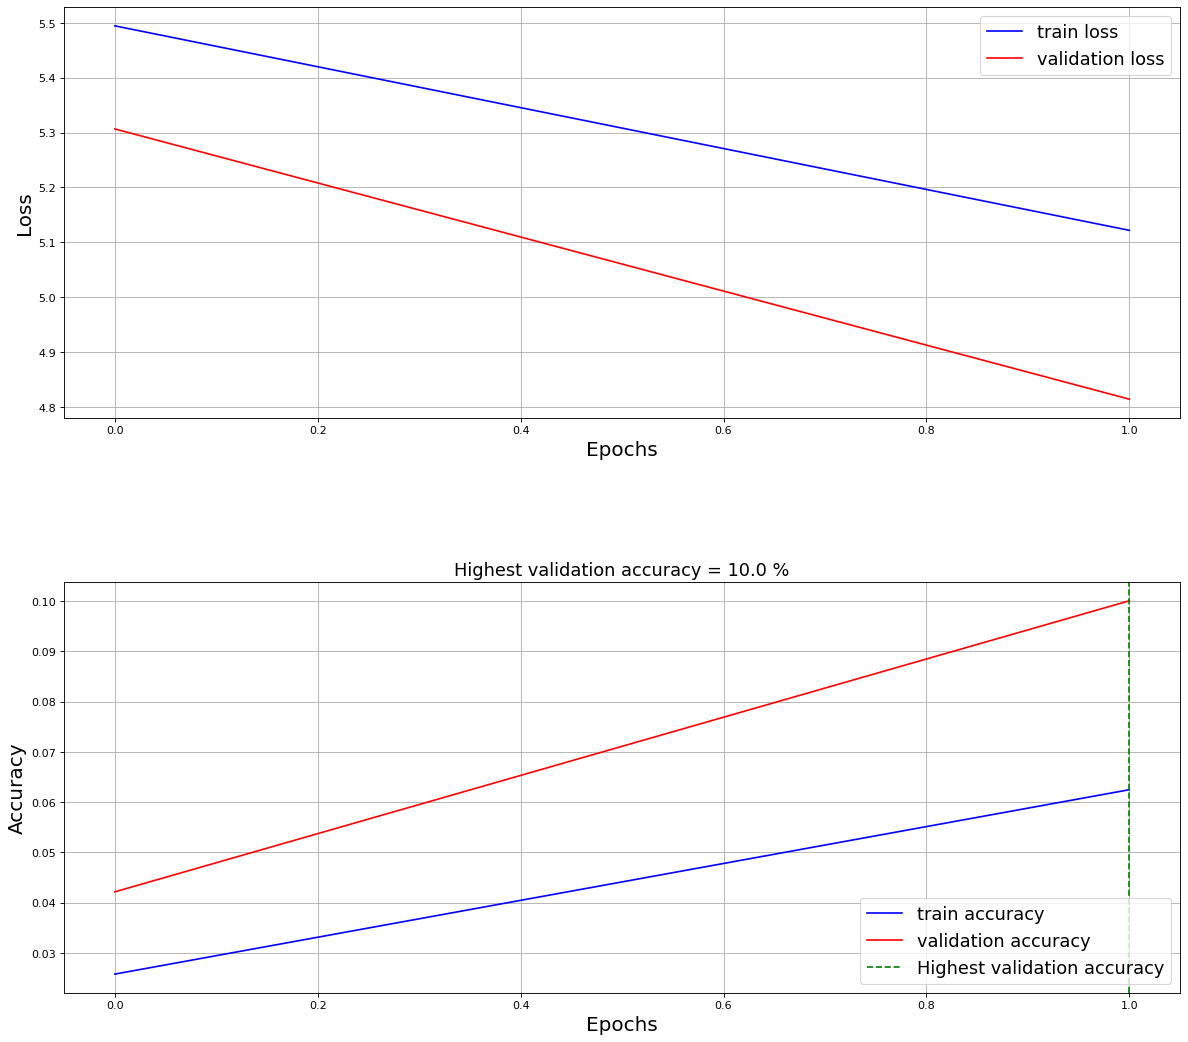

In [75]:
# Plot the loss and the accuracy in training and validation
# plt.figure()
plt.figure(figsize=(18, 16), dpi=80, facecolor="w", edgecolor="k")
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, "b", label="train loss")
ax.plot(val_loss, "r", label="validation loss")
ax.grid()
plt.ylabel("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=18)
ax.legend(loc="upper right", fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, "b", label="train accuracy")
ax.plot(val_acc, "r", label="validation accuracy")
ax.grid()
plt.ylabel("Accuracy", fontsize=18)
plt.xlabel("Epochs", fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)
plt.axvline(
    x=val_acc_max_ind, color="g", linestyle="--", label="Highest validation accuracy"
)
plt.title("Highest validation accuracy = %0.1f %%" % (val_acc_max * 100), fontsize=16)
ax.legend(loc="lower right", fontsize=16)
plt.ion()

In [78]:
ind = np.argmax(val_acc)
class_accuracy = val_confusion_matrix[:, :, ind]
for ii in range(num_classes):
    acc = val_confusion_matrix[ii, ii, ind] / np.sum(val_confusion_matrix[ii, :, ind])
    print(f"Accuracy of {str(label_list[ii]).ljust(15)}: {acc*100:.01f}%")

Accuracy of 0              : 0.0%
Accuracy of 1              : 0.0%
Accuracy of 2              : 0.0%
Accuracy of 3              : 0.0%
Accuracy of 4              : 0.0%
Accuracy of 5              : 0.0%
Accuracy of 6              : 0.0%
Accuracy of 7              : 0.0%
Accuracy of 8              : 0.0%
Accuracy of 9              : 0.0%
Accuracy of 10             : 0.0%
Accuracy of 11             : 0.0%
Accuracy of 12             : 0.0%
Accuracy of 13             : 0.0%
Accuracy of 14             : 0.0%
Accuracy of 15             : 0.0%
Accuracy of 16             : 0.0%
Accuracy of 17             : 0.0%
Accuracy of 18             : 0.0%
Accuracy of 19             : 0.0%
Accuracy of 20             : 0.0%
Accuracy of 21             : 0.0%
Accuracy of 22             : 0.0%
Accuracy of 23             : 0.0%
Accuracy of 24             : 0.0%
Accuracy of 25             : 0.0%
Accuracy of 26             : 0.0%
Accuracy of 27             : 0.0%
Accuracy of 28             : 0.0%
Accuracy of 29

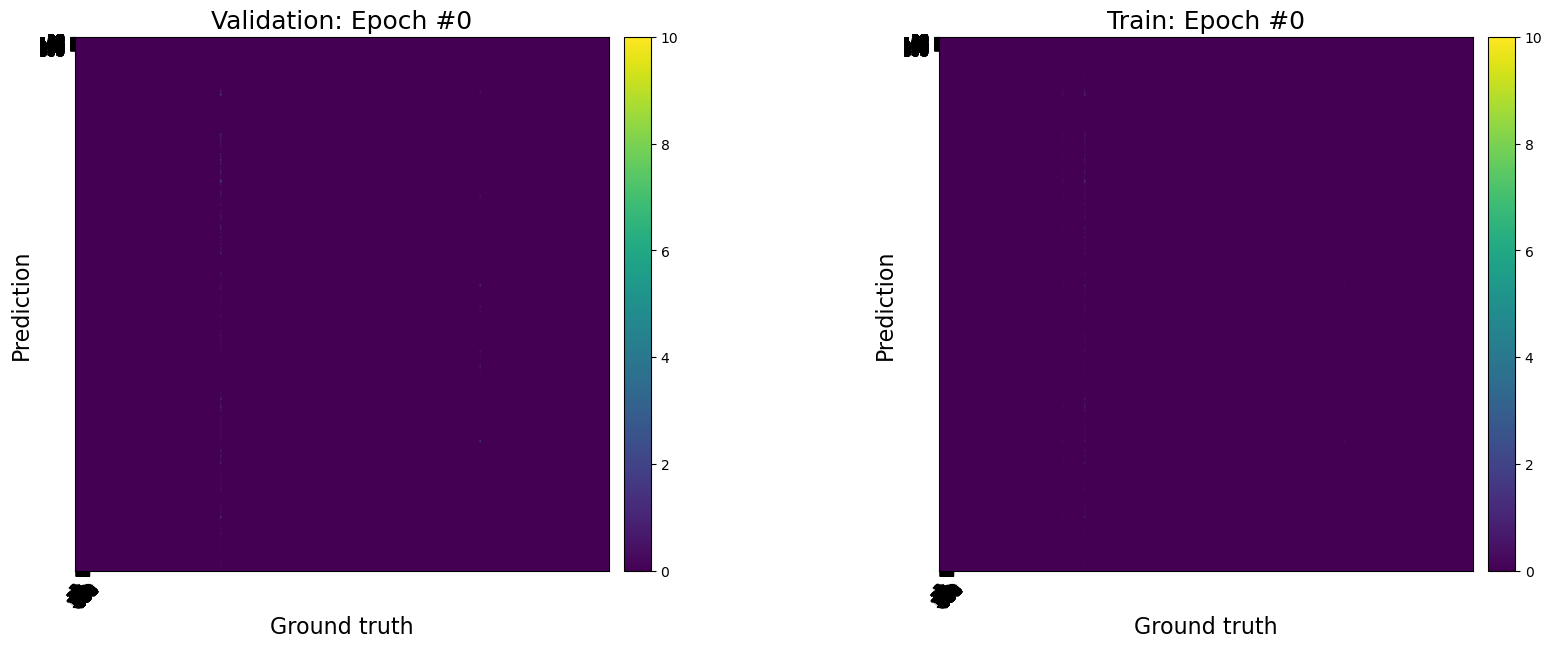

In [82]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epoch_step = 2
set_colorbar_max_percentage = 10

# Plot confusion matrices
ticks = np.linspace(0, 9, num_classes)
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.0, right=0.9, wspace=0.5, hspace=0.2)
for i in range(0, epochs, epoch_step):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16), gridspec_kw=gridspec_kwargs)
    im = ax1.imshow(val_confusion_matrix[:, :, i] * 100)
    ax1.set_title(f"Validation: Epoch #{i}", fontsize=18)
    ax1.set_xticks(ticks=ticks)
    ax1.set_yticks(ticks=ticks)
    ax1.set_yticklabels(label_list)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax1.set_xticklabels(label_list, rotation=45)
    ax1.set_ylabel("Prediction", fontsize=16)
    ax1.set_xlabel("Ground truth", fontsize=16)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    f.colorbar(im, cax=cax, orientation="vertical")

    im = ax2.imshow(train_confusion_matrix[:, :, i] * 100)
    ax2.set_title(f"Train: Epoch #{i}", fontsize=18)
    ax2.set_xticks(ticks=ticks)
    ax2.set_yticks(ticks=ticks)
    ax2.set_yticklabels(label_list)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax2.set_xticklabels(label_list, rotation=45)
    ax2.set_ylabel("Prediction", fontsize=16)
    ax2.set_xlabel("Ground truth", fontsize=16)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    f.colorbar(im, cax=cax, orientation="vertical")